
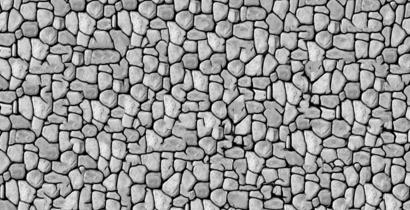

# Texture Quilting

In this assignment, you will develop code to stitch together image patches sampled from an input texture in order to synthesize new texture images. You can download the test image used to generate the example above from assignment folder Canvas.

You should start by reading through the whole assignment, looking at the provided code in detail to make sure you understand what it does. The main fucntion ***quilt_demo*** appears at the end. You will need to write several subroutines in order for it to function properly.

---

***Name:*** Owen Yang

***SID:***   16009025

---
# 1. Shortest Path [25 pts]


Write a function ***shortest_path*** that takes an 2D array of ***costs***, of shape HxW, as input and finds the *shortest vertical path* from top to bottom through the array. A vertical path is specified by a single horizontal location for each row of the H rows. Locations in successive rows should not differ by more than 1 so that at each step the path either goes straight or moves at most one pixel to the left or right. The cost is the sum of the costs of each entry the path traverses. Your function should return an length H vector that contains the index of the path location (values in the range 0..W-1) for each of the H rows.

You should solve the problem by implementing the dynamic programming algorithm described in class. You will have a for-loop over the rows of the "cost-to-go" array (M in the slides), computing the cost of the shortest path up to that row using the recursive formula that depends on the costs-to-go for the previous row. Once you have get to the last row, you can then find the smallest total cost. To find the path which actually has this smallest cost, you will need to do  backtracking. The easiest way to do this is to also store the index of whichever minimum was selected at each location. These indices will also be an HxW array. You can then backtrack through these indices, reading out the path.

Finally, you should create at least three test cases by hand where you know the shortest path and see that the code gives the correct answer.

In your implementation you will need to have a *for-loop* over the rows of the cost matrix since the computation has to be carried out in a squential order.  However, the computation for each row can be done in a vectorized manner without an explicit loop  (e.g., my implementation used the **numpy** operations  **concatenate,stack,min,argmin**). If you get stuck I recommend first implementing a version with nested loops to make sure you get the algorithm correct and then go back and see how to "vectorize" it. 

In [1]:
#modules used in your code
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [2]:
def shortest_path(costs):
    """
    This function takes an array of costs and finds a shortest path from the 
    top to the bottom of the array which minimizes the total costs along the
    path. The path should not shift more than 1 location left or right between
    successive rows.
    
    In other words, the returned path is one that minimizes the total cost:
        
        total_cost = costs[0,path[0]] + costs[1,path[1]] + costs[2,path[2]] + ...

    subject to the constraint that:
    
        abs(path[i]-path[i+1])<=1
    
    Parameters
    ----------
    costs : 2D float array of shape HxW
         An array of cost values with W>=3
    
    Returns
    -------
    path : 1D array of length H
        indices of a vertical path.  path[i] contains the column index of 
        the path for each row i. 
    """

    nrows = costs.shape[0]
    ncols = costs.shape[1]
    
    # to keep the implementation simple, we will refuse to handle
    # the boundary case where the cost array is very narrow.
    assert(ncols>=3)
    
    #intialize path array
    path = np.zeros(costs.shape[0],dtype=int)
    
    #intialize costs-to-go array M
    M = np.zeros(costs.shape)
    M[0] = costs[0]
    
    #intialize array for backtracking
    Q = np.zeros((costs.shape[0],costs.shape[1]+2),dtype=int)
    
    #pad left and right M with infinities to prevent out of bounds error
    infCol = np.full((costs.shape[0],1),float('inf'))
    M = np.hstack((infCol,M,infCol))
    
    #vectorized dp algo to generate M and Q 
    for i in range(1,costs.shape[0]):
        #compute M by stacking left, middle, and right and finding min 
        middle = M[i-1,1:M.shape[1]-1]
        left = M[i-1,:M.shape[1]-2]
        right = M[i-1,2:]        
        mini = np.dstack((left,middle,right)).min(axis=(0,2))
        M[i,1:M.shape[1]-1] = costs[i,:] + mini

        #compute Q by using argmin on stacked l,m,r, adding column indices, 
        # and subtracting 2 for padding
        col = np.mgrid[0:1,0:M.shape[1]][1][:,1:M.shape[1]-1] 
        Q[i,1:Q.shape[1]-1] = col+np.dstack((left,middle,right)).argmin(axis=2)-2 
        
    #delete padding from M and Q
    M = M[:,1:M.shape[1]-1]
    Q = Q[:,1:Q.shape[1]-1]
    
    #find the smallest entry in the last row of M
    path[-1] = np.argmin(M[-1])
    
    #backtrack through Q to compute shortest path
    j = path[-1]
    for i in range(M.shape[0]-1,-1,-1):
        path[i] = j
        j = Q[i,j]

    return path

In [3]:
#
# Your test code goes here.  Come up with at least 3 test cases by manually
# constructing a cost matrix where you know what the shortest path should be.
#

# One of your tests should be a case where a simple greedy forward search
# (i.e., finding the min in the first row and then repeatedly choosing the 
# min of the 3 neighbors below it) fails but your dynamic program finds the
# global optimum.
#

#Test 1 (Greedy forward search should fail here)
costs1 = np.array([[1,100,10],[11,100,1],[12,100,1],[13,100,1]])
path1 = shortest_path(costs1)

print('Test 1') # greedy search would have resulted in [0,0,0,0]
assert((path1==np.array([2,2,2,2])).all())
print('costs1:\n',costs1)
print('path1:',path1)
print()

#Test 2 (Greedy forward search should fail here)
costs2 = np.array([[1,5,4,8,6,10],[4,2,8,9,10,2],[11,10,13,4,3,6],[15,12,16,1,4,7],[14,23,18,23,5,16]])
path2 = shortest_path(costs2)
print('Test 2') 
assert((path2==np.array([4,5,4,3,4])).all())
print('costs2:\n',costs2)
print('path2:',path2)
print()

#Test 3 
costs3 = np.array([[3,6,4,1],[4,7,8,3],[1,10,4,4],[15,12,16,1],[14,4,7,23],[16,8,2,4],[7,8,6,9],[1,12,1,1]])
path3 = shortest_path(costs3)
print('Test 3') 
assert((path3==np.array([3,3,2,3,2,2,2,2])).all())
print('costs3:\n',costs3)
print('path3:',path3)
print()

#Test 4 
costs4 = np.array([[23,23,23,23,23],[23,23,23,23,23],[23,10,23,23,23],[23,23,23,23,23]])
path4 = shortest_path(costs4)

print('Test 4') 
assert((path4==np.array([0,0,1,0])).all())
print('costs4:\n',costs4)
print('path4:',path4)
print()

#Test 5 
costs5 = np.array([[3,5,6,7],[7,1,5,3],[3,5,1,7],[7,6,5,3]])
path5 = shortest_path(costs5)

print('Test 5') 
assert((path5==np.array([0,1,2,3])).all())
print('costs5:\n',costs5)
print('path5:',path5)
print()


Test 1
costs1:
 [[  1 100  10]
 [ 11 100   1]
 [ 12 100   1]
 [ 13 100   1]]
path1: [2 2 2 2]

Test 2
costs2:
 [[ 1  5  4  8  6 10]
 [ 4  2  8  9 10  2]
 [11 10 13  4  3  6]
 [15 12 16  1  4  7]
 [14 23 18 23  5 16]]
path2: [4 5 4 3 4]

Test 3
costs3:
 [[ 3  6  4  1]
 [ 4  7  8  3]
 [ 1 10  4  4]
 [15 12 16  1]
 [14  4  7 23]
 [16  8  2  4]
 [ 7  8  6  9]
 [ 1 12  1  1]]
path3: [3 3 2 3 2 2 2 2]

Test 4
costs4:
 [[23 23 23 23 23]
 [23 23 23 23 23]
 [23 10 23 23 23]
 [23 23 23 23 23]]
path4: [0 0 1 0]

Test 5
costs5:
 [[3 5 6 7]
 [7 1 5 3]
 [3 5 1 7]
 [7 6 5 3]]
path5: [0 1 2 3]



# 2. Image Stitching: [25 pts]


Write a function ***stitch*** that takes two gray-scale images, ***left_image*** and ***right_image*** and a specified ***overlap*** and returns a new output image by stitching them together along a vertical seam where the two images have very similar brightness values. If the input images are of widths ***w1*** and ***w2*** then your stitched result image returned by the function should be of width ***w1+w2-overlap*** and have the same height as the two input images.

You will want to first extract the overlapping strips from the two input images and then compute a cost array given by the absolute value of their difference. You can then use your ***shortest_path*** function to find the seam along which to stitch the images where they differ the least in brightness. Finally you need to generate the output image by using pixels from the left image on the left side of the seam and from the right image on the right side of the seam. You may find it easiest to code this by first turning the path into an binary (alpha) mask for each image and then using the standard blending approach we used in the previous assignment.

In [4]:
def stitch(left_image, right_image, overlap):
    """
    This function takes a pair of images with a specified overlap and stitches them
    togther by finding a minimal cost seam in the overlap region.
    
    Parameters
    ----------
    left_image : 2D float array of shape HxW1
        Left image to stitch 
    
    right_image : 2D float array of shape HxW2
        Right image to stitch 

    overlap : int
        Width of the overlap zone between left and right image
        
    Returns
    -------
    stitched : 2D float array of shape Hx(W1+W2-overlap)
        The resulting stitched image
    """
    
    # inputs should be the same height
    assert(left_image.shape[0]==right_image.shape[0])
    assert(overlap>=3)
    
    # slice overlap arrays
    left_overlap = left_image[:,left_image.shape[1]-overlap:]
    right_overlap = right_image[:,:overlap]
    
    #compute cost array
    costs = np.absolute(left_overlap-right_overlap)
    
    #compute shortest path using cost array
    path = shortest_path(costs)
    
    #create binary masks
    
    p = np.hstack(([path[:,None]]*overlap))
    g = np.mgrid[0:left_image.shape[0],0:overlap][1]

    left_mask = np.where(g>=p, -1, 1) #set seam and right of seam to -1, and left to  1
    right_mask = np.where(g<p, -1, 1) #set left of seam to -1, and right to  1

    #filter alpha masks
    left_alpha = gaussian_filter(left_mask,1,output=float) 
    right_alpha = gaussian_filter(right_mask,1,output=float)
    
    #set negatives to zeros
    left_alpha[left_alpha<0]=0
    right_alpha[right_alpha<0]=0
    
    #set alphas to zero where masks are zero
    left_alpha *= left_mask
    right_alpha *= right_mask
    
    # normalize alphas by dividing each alpha by sum of alphas; skip division when sum is 0
    aSum = left_alpha + right_alpha
    left_alpha = np.divide(left_alpha,aSum, where=aSum!=0)
    right_alpha = np.divide(right_alpha,aSum, where=aSum!=0)
    
    #apply alpha masks and stitch images together
    stitched = left_alpha*left_overlap + right_alpha*right_overlap
    stitched = np.hstack((left_image[:,:left_image.shape[1]-overlap],stitched,right_image[:,overlap:]))
    
    assert(stitched.shape[0]==left_image.shape[0])
    assert(stitched.shape[1]==(left_image.shape[1]+right_image.shape[1]-overlap))
    
    return stitched
    
    

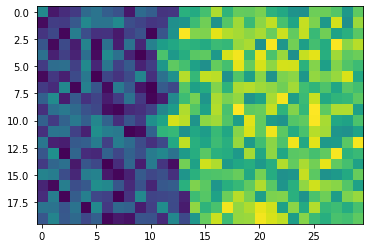

In [5]:
# a simple test visualization of stitching two random
# tiles which have different overall brightness so we
# can easily see where the seam is

L = np.random.rand(20,20)+1
R = np.random.rand(20,20)+2
S = stitch(L,R,10)
plt.imshow(S)
plt.show()

# 3. Texture Quilting: [25 pts]

Write a function ***synth_quilt*** that takes as input an array indicating the set of texture tiles to use, an array containing the set of available texture tiles, the ***tilesize*** and ***overlap*** parameters and synthesizes the output texture by stitching together the tiles. ***synth_quilt*** should utilize your stitch function repeatedly. First, for each horizontal row of tiles, construct the stitched row by successively stitching the next tile in the row on to the right side of your row image. Once you have row images for all the rows, you can stitch them together to get the final image. Since your stitch function only works for vertical seams, you will want to transpose the rows, stitch them together, and then transpose the result. You may find it useful to look at the provided code below which simply puts down the tiles with the specified overlap but doesn't do stitching. Your quilting function will return a similar result but with much smoother transitions between the tiles.

In [6]:
def synth_quilt(tile_map,tiledb,tilesize,overlap):
  
    """
    This function takes as input an array indicating the set of texture tiles 
    to use at each location, an array containing the database of available texture 
    tiles, tilesize and overlap parameters, and synthesizes the output texture by 
    stitching together the tiles

    
    Parameters
    ----------
    tile_map : 2D array of int
        Array storing the indices of which tiles to paste down at each output location 
    
    tiledb : 2D array of int 
        Collection of sample tiles to select from. The array is of size ntiles x npixels 
        where each tile image is stored in vectorized form as a row of the array.
        
    tilesize : (int,int)
        Size of a tile in pixels
        
    overlap : int
        Amount of overlap between tiles
        
    Returns
    -------
    output : 2D float array
        The resulting synthesized texture of size
    """
    
    # determine output size based on overlap and tile size
    outh = (tilesize[0]-overlap)*tile_map.shape[0] + overlap
    outw = (tilesize[1]-overlap)*tile_map.shape[1] + overlap

    output = np.array([])
    for i in range(tile_map.shape[0]):
        row = tiledb[tile_map[i,0],:].reshape(tilesize).copy()
        for j in range(1,tile_map.shape[1]):
            left_image = row
            right_image = tiledb[tile_map[i,j],:].reshape(tilesize)
            row = stitch(left_image,right_image,overlap)
        if output.size != 0:
            output = stitch(output,row.T,overlap)
        else:
            output = row.T
    
    assert(output.shape==(outw,outh))
    
    return output.T


# 4. Texture Synthesis Demo [25pts]

The function provided below ***quilt_demo*** puts together the pieces. It takes a sample texture image and a specified output size and uses the functions you've implemented previously to synthesize a new texture sample.

You should write some additional code in the cells that follow to in order demonstrate the final result and experiment with the algorithm parameters in order to produce a compelling visual result and write explanations of what you discovered.

Test your code on the provided image *rock_wall.jpg*. There are three parameters of the algorithm. The *tilesize*, *overlap* and *K*. In the provided ***texture_demo*** code below, these have been set at some default values. Include in your demo below images of three example texture outputs when you: (1) increase the tile size, (2) decrease the overlap, and (3) increase the value for K. For each result explain how it differs from the default setting of the parameters and why.

Test your code on two other texture source images of your choice. You can use images from the web or take a picture of a texture yourself. You may need to resize or crop your input image to make sure that the ***tiledb*** is not overly large. You will also likely need to modify the ***tilesize*** and ***overlap*** parameters depending on your choice of texture. Once you have found good settings for these parameters, synthesize a nice output texture. Make sure you display both the image of the input sample and the output synthesis for your two other example textures in your submitted pdf. 


In [7]:
#skimage is only needed for sample tiles code provided below
#you should not use it elsewhere in your own code
import skimage as ski 

def sample_tiles(image,tilesize,randomize=True):
    """
    This function generates a library of tiles of a specified size from a given source image
       
    Parameters
    ----------
    image : float array of shape HxW
        Input image 
            
    tilesize : (int,int)
        Dimensions of the tiles in pixels
        
        
    Returns
    -------
    tiles : float array of shape  numtiles x numpixels
        The library of tiles stored as vectors where npixels is the 
        product of the tile height and width     
    """
    
    tiles = ski.util.view_as_windows(image,tilesize)
    ntiles = tiles.shape[0]*tiles.shape[1]
    npix = tiles.shape[2]*tiles.shape[3]
    assert(npix==tilesize[0]*tilesize[1])
    
    print("library has ntiles = ",ntiles,"each with npix = ",npix)
    
    tiles = tiles.reshape((ntiles,npix)) 
    
    # randomize tile order
    if randomize:
        tiles = tiles[np.random.permutation(ntiles),:]
    
    return tiles


def topkmatch(tilestrip,dbstrips,k):
    """
    This function finds the top k candidate matches in dbstrips that
    are most similar to the provided tile strip.
      
    Parameters
    ----------
    tilestrip : 1D float array of length npixels
        Grayscale values of the query strip 
    
    dbstrips : 2D float array of size npixels x numtiles
        Array containing brightness values of numtiles strips in the database 
        to match to the npixels brightness values in tilestrip
                
    k : int
        Number of top candidate matches to sample from
        
    Returns
    -------
    matches : list of ints of length k
        The indices of the k top matching tiles   
    """
    assert(k>0)
    assert(dbstrips.shape[0]>k)
    error = (dbstrips-tilestrip)
    ssd = np.sum(error*error,axis=1)
    ind = np.argsort(ssd)
    matches = ind[0:k]
    return matches


def quilt_demo(sample_image, ntilesout=(10,20), tilesize=(30,30), overlap=5, k=5):
    """
    This function takes an image and quilting parameters and synthesizes a
    new texture image by stitching together sampled tiles from the source image.

     
    Parameters
    ----------
    sample_image : 2D float array
        Grayscale image containing sample texture 
    
    ntilesout : list of int
        Dimensions of output in tiles,  e.g. (3,4)
        
    tilesize : int
        Size of the square tile in pixels
        
    overlap : int
        Amount of overlap between tiles
        
    k : int
        Number of top candidate matches to sample from
        
    Returns
    -------
    img : list of int of length K
        The resulting synthesized texture of size           
    """
    
    # generate database of tiles from sample
    tiledb = sample_tiles(sample_image,tilesize)
    # number of tiles in the database
    nsampletiles = tiledb.shape[0]
    
    if (nsampletiles<k):
        print("Error: tile database is not big enough!")

    # generate indices of the different tile strips so we can easily
    # extract the left, right, top or bottom overlap strip from a tile
    i,j = np.mgrid[0:tilesize[0],0:tilesize[1]]
    top_ind = np.ravel_multi_index(np.where(i<overlap),tilesize)
    bottom_ind = np.ravel_multi_index(np.where(i>=tilesize[0]-overlap),tilesize)
    left_ind = np.ravel_multi_index(np.where(j<overlap),tilesize)
    right_ind = np.ravel_multi_index(np.where(j>=tilesize[1]-overlap),tilesize)

    # initialize an array to store which tile will be placed
    # in each location in the output image
    tile_map = np.zeros(ntilesout,'int')
    
    print('row:', end=' ')
    for i in range(ntilesout[0]):
        print(i, end=' ')
        for j in range(ntilesout[1]):
            
            if (i==0)&(j==0):                  # first row first tile
                matches = np.zeros(k) #range(nsampletiles)
            
            elif (i==0):                       # first row (but not first tile)
                left_tile = tile_map[i,j-1]
                tilestrip = tiledb[left_tile,right_ind]
                dbstrips = tiledb[:,left_ind]
                matches = topkmatch(tilestrip,dbstrips,k)
                
            elif (j==0):                       # first column (but not first row)
                above_tile = tile_map[i-1,j]
                tilestrip = tiledb[above_tile,bottom_ind]
                dbstrips = tiledb[:,top_ind] 
                matches = topkmatch(tilestrip,dbstrips,k)
                
            else:                              # neigbors above and to the left
                left_tile = tile_map[i,j-1]
                tilestrip_1 = tiledb[left_tile,right_ind]
                dbstrips_1 = tiledb[:,left_ind]
                above_tile = tile_map[i-1,j]
                tilestrip_2 = tiledb[above_tile,bottom_ind]
                dbstrips_2 = tiledb[:,top_ind]
                # concatenate the two strips
                tilestrip = np.concatenate((tilestrip_1,tilestrip_2))
                dbstrips = np.concatenate((dbstrips_1,dbstrips_2),axis=1)
                matches = topkmatch(tilestrip,dbstrips,k)
                
            #choose one of the k matches at random
            tile_map[i,j] = matches[np.random.randint(0,k)]
    
    output = synth_quilt(tile_map,tiledb,tilesize,overlap)
    
    return output


library has ntiles =  29241 each with npix =  900
row: 0 1 2 3 4 5 6 7 8 9 

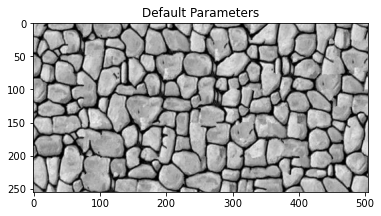

library has ntiles =  22801 each with npix =  2500
row: 0 1 2 3 4 5 6 7 8 9 

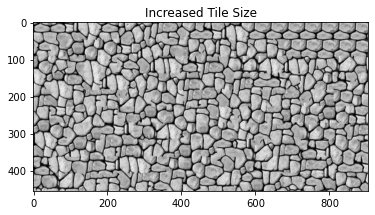

library has ntiles =  29241 each with npix =  900
row: 0 1 2 3 4 5 6 7 8 9 

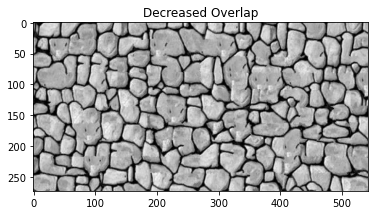

library has ntiles =  29241 each with npix =  900
row: 0 1 2 3 4 5 6 7 8 9 

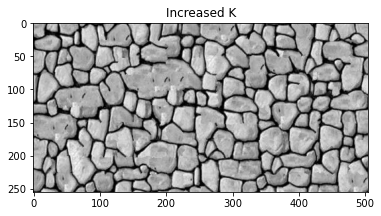

In [8]:
# load in rock_wall.jpg
# run and display results for quilt_demo with 
#
# (0) default parameters
# (1) increased tile size
# (2) decrease the overlap 
# (3) increase the value for K.

#load image
I = plt.imread('rock_wall.jpg')

#convert to float and grayscale
if (I.dtype == np.uint8):
    I = np.mean(I.astype(float) / 256,axis=-1)
    
# (0) Default Parameters
plt.imshow(quilt_demo(I),cmap=plt.cm.gray)
plt.title("Default Parameters")
plt.show()

# (1) Increased Tile Size
plt.imshow(quilt_demo(I,tilesize=(50,50)),cmap=plt.cm.gray)
plt.title("Increased Tile Size")
plt.show()

# (2) Decreased Overlap
plt.imshow(quilt_demo(I,overlap=3),cmap=plt.cm.gray)
plt.title("Decreased Overlap")
plt.show()

# (3) Increased K
plt.imshow(quilt_demo(I,k=10),cmap=plt.cm.gray)
plt.title("Increased K")
plt.show()

***For each result shown, explain here how it differs visually from the default setting of the parameters and explain why:***

.(1) Increased Tile Size: Increasing the tile size spread the rockwall pattern out onto a larger canvas, which resulted in a larger output image. The size of each of the tile images increased, so after quilting the overall output image grew much bigger.

.(2) Decreased Overlap: Decreasing the overlap from the default of 5 to the minumum of 3 made no noticeable difference besides making the output image slightly larger. The 2 pixel difference might be so slight that it causes almost no visual change within the overall pattern of the image. However, in theory, decreasing from a much higher overlap to a much lower one should increase the overall output image size, while also decreasing the area of blending done between overlapped tiles, which would make the seams between tiles less blended and a bit sharper.

.(3) Increased K: Increasing K made almost no discernable difference. In theory, increasing K should have resulted in the rockwall pattern becoming more varied since there will be a higher number of tile matches to choose from. However, since the source rockwall image has a somewhat consistent pattern, the tile samples will all look very similar. As a result, increasing the K did not have much of an affect on this rockwall pattern.

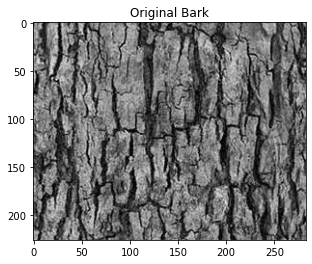

library has ntiles =  45628 each with npix =  1600
row: 0 1 2 3 4 5 6 7 8 9 

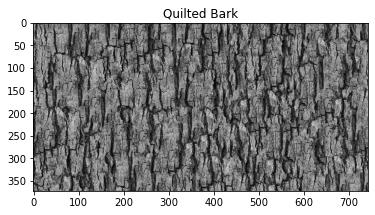

In [9]:
#
# load in yourimage1.jpg
#
# call quilt_demo, experiment with parameters as needed to get a good result
#
# display your source image and the resulting synthesized texture
#
I = plt.imread('bark.jpg')

#convert to float and grayscale
if (I.dtype == np.uint8):
    I = np.mean(I.astype(float) / 256,axis=-1)
    
plt.imshow(I,cmap=plt.cm.gray)
plt.title("Original Bark")
plt.show()    
    
plt.imshow(quilt_demo(I,tilesize=(40,40),overlap=3,k=10),cmap=plt.cm.gray)
plt.title("Quilted Bark")
plt.show()

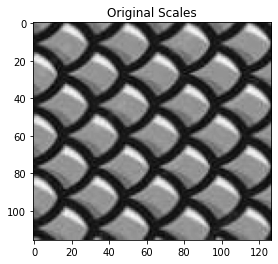

library has ntiles =  6776 each with npix =  1600
row: 0 1 2 3 4 5 6 7 8 9 

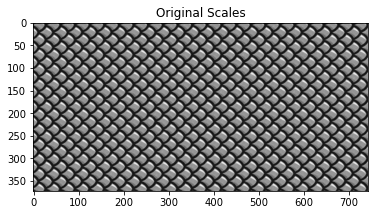

In [10]:
#
# load in yourimage2.jpg
#
# call quilt_demo, experiment with parameters as needed to get a good result
#
# display your source image and the resulting synthesized texture
#
I = plt.imread('scales.jpg')

#convert to float and grayscale
if (I.dtype == np.uint8):
    I = np.mean(I.astype(float) / 256,axis=-1)

plt.imshow(I,cmap=plt.cm.gray)
plt.title("Original Scales")
plt.show()    

plt.imshow(quilt_demo(I,tilesize=(40,40),overlap=3,k=2),cmap=plt.cm.gray)
plt.title("Original Scales")
plt.show()